In [ ]:
import os
import spacy
nlp = spacy.load("en_core_web_sm")
from google.colab import drive
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import nltk
import json
import requests
import urllib.request
from bs4 import BeautifulSoup
import tarfile
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import regex as re
import glob
from scipy.special import expit
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Scraper returns list of sentences
def scrapeBody(url):
  URL_raw = url
  URL = URL_raw.strip().replace(" ", "+")
  try:
    page = requests.get(URL)
  except:
    print("Could not find URL..")
  htmlParse = BeautifulSoup(page.content, 'html.parser')
  input = ""
  for para in htmlParse.find_all("p"):
      input = input + (para.get_text())
  doc = nlp(input)
  sentenceList = [sent.text.strip() for sent in doc.sents]
  #Randomly Split and go through the List and add to dataframe
  return (sentenceList)



In [ ]:
drive.mount("drive")
baselinedf = pd.read_table('drive/MyDrive/Coding Portfolio/NewsScraperProject/Datasets/wikisent2.txt', header=None)
baselinedf = baselinedf[1000000:6000000]

Mounted at drive


In [ ]:
#Add Non Biased Sentence Dataframe
cutbaselinedf = pd.DataFrame(np.empty((2500, 2)))

cutbaselinedf.columns = ["label", "text"]
sentencelist1 = []
cutbaselinedf = cutbaselinedf.assign(label='Non-biased')
for i in range(2500):
  sentencelist1.append(baselinedf[0][random.randint(1000000, 6000000)])
cutbaselinedf["text"] = sentencelist1
display(cutbaselinedf)

,label,text
0,Non-biased,Its ales include Top Totty.
1,Non-biased,Ptah Amissah-Aidoo changed his life.
2,Non-biased,Spyboy is a 1998 live album by Emmylou Harris ...
3,Non-biased,He still plays in the occasional match for cha...
4,Non-biased,He debuted as a solo artist in 2005 with the a...
...,...,...
2495,Non-biased,He was purported to have died in California in...
2496,Non-biased,South Moreton Castle was an 11th-century castl...
2497,Non-biased,The 1954 VFL Grand Final was an Australian rul...
2498,Non-biased,"Peter Green sings lead vocals on ""You Don't Lo..."


# Prepare Bias Model Using Bigrams

In [ ]:
#--------Get Data and Initialize--------
!wget https://www.cs.cornell.edu/home/llee/data/convote/convote_v1.1.tar.gz
!tar -xf convote_v1.1.tar.gz

var = open("/content/convote_v1.1/data_stage_one/development_set/052_400239_1479098_ROY.txt", "r")
nltk.download('stopwords')
stops = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
htmlstops = ["amp", "nbsp", "tab", "newline", "lpar", "l", "rpar", "r", "lt", "gt", "centerdot"]
for i in htmlstops:
  stops.add(i)

#--------CreateBigrams Function--------
def createBigrams(sentences):
  grams = []
  result = re.sub(r'&[a-z]+', ' ',  sentences)
  tokenedSentence = tokenizer.tokenize(result)
  for i in range(len(tokenedSentence)-1):
    temp = (tokenedSentence[i], tokenedSentence[i+1])
    grams.append(temp)
  clean = [gram for gram in grams if not any(stop in gram for stop in stops)]
  
  return clean

#--------Get All Sentences from Data Stage One Set to get demgram and repgram--------
allsentences = glob.glob("/content/convote_v1.1/data_stage_one/development_set/*.txt")
demgram = []
repgram = []
for i in allsentences:
  temp = open(i, "r")
  if("D" in i):
    demgram = createBigrams(temp.read()) + demgram
  else:
    repgram = createBigrams(temp.read()) + repgram

#--------Union the Sets--------
uniongram = set(demgram).intersection(set(repgram))
# "bigram" : Frequency
demdict = {}
repdict = {}
for i in demgram:
  if i not in uniongram:
    demdict[i] = demdict.get(i, 0) + 1
demdict = sorted(demdict.items(), key=lambda item: item[1], reverse=True)

for i in repgram:
  if i not in uniongram:
    repdict[i] = repdict.get(i, 0) + 1
repdict = sorted(repdict.items(), key=lambda item: item[1], reverse=True)

#--------Initialize Model--------
a = []
b = []
for i in range(200):
    a.append(0)
    b.append(1)

df1 = pd.DataFrame(demdict[:200])
df1['target'] = a;
df2 = pd.DataFrame(repdict[:200])
df2['target'] = b;

frames = [df1, df2]
biasdata = pd.concat(frames)

def cleanData(tuple1):
  return tuple1[0] + " " + tuple1[1]

biasdata[0] = biasdata[0].apply(cleanData)

X_train,X_test,y_train,y_test = train_test_split(biasdata[0], biasdata.target, test_size=0.2, random_state=42)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])
#--------Fitting the model--------
biasmodelBiGram = pipe.fit(X_train, y_train)
#Accuracy
prediction = biasmodelBiGram.predict(X_test)

print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print((mean_absolute_error(y_test, prediction)))
print(f1_score(y_test, prediction))

--2022-06-19 02:15:54--  https://www.cs.cornell.edu/home/llee/data/convote/convote_v1.1.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9837902 (9.4M) [application/x-gzip]
Saving to: ‘convote_v1.1.tar.gz’

convote_v1.1.tar.gz 100%[===================>]   9.38M  24.2MB/s    in 0.4s    

2022-06-19 02:15:55 (24.2 MB/s) - ‘convote_v1.1.tar.gz’ saved [9837902/9837902]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


accuracy: 61.25%
0.3875
0.6804123711340206


# Bias Model with Annotations Dataset

In [ ]:
drive.mount("drive")
biasdf2 = pd.read_excel('drive/MyDrive/Coding Portfolio/NewsScraperProject/Datasets/annotations.xlsx', header=None)
#columns 8, 12, 13, and 14 are useful but are not used for code in line 8
biasdf2.drop(columns=[0, 1, 2, 3, 4, 5, 7, 9, 11, 15, 16, 17, 18, 19 , 20, 21, 22, 23, 8, 12, 13, 14 ], inplace=True)
biasdf2.rename(columns={6:"label", 10:"text"}, inplace=True)
biasdf2.dropna(inplace=True)
print(biasdf2["label"].value_counts())
# concat with nonbias dataframe made above
frames = [cutbaselinedf, biasdf2]
biasdf3 = pd.concat(frames)
display(biasdf2)
def numerateBias(label):
  if label == "Non-biased":
    return 0
  else:
    return 1
  return 1
biasdf3["label"] = biasdf3["label"].apply(numerateBias)


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Biased        10651
Non-biased     7124
label             1
Name: label, dtype: int64


,label,text
0,label,text
1,Non-biased,The transgender effort to suppress any recogni...
2,Non-biased,Radical Virginia Citizens Defense League has o...
3,Non-biased,Miller is the architect of President Donald Tr...
4,Non-biased,"The House Democrats’ 1,400-page coronavirus re..."
...,...,...
17771,Biased,Oregon first graders could attend gun safety c...
17772,Biased,But President Donald Trump and his campaign ad...
17773,Biased,The normalization effort included softened rhe...
17774,Biased,"And so, while demonstrations began to spread a..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(biasdf3["text"], biasdf3["label"], test_size=0.2, random_state=42)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
#--------Fitting the model--------
biasmodelAnno = pipe.fit(X_train, y_train)
#Accuracy
prediction = biasmodelAnno.predict(X_test)

print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print((mean_absolute_error(y_test, prediction)))
print(f1_score(y_test, prediction))

accuracy: 70.88%
0.2911735700197239
0.7311632142044162


# Initialize Fake Model 






In [ ]:
!wget https://www.cs.ucsb.edu/~william/data/liar_dataset.zip
!unzip /content/liar_dataset.zip
Fakedf = pd.read_csv("train.tsv", sep="\t")
Fakedf.dropna(inplace=True)
Fakedf.reset_index(drop=True, inplace=True)
Fakedf.rename({"false": "label", "Says the Annies List political group supports third-trimester abortions on demand.": "Text", "republican":"party"}, axis = 1, inplace=True)
# Fakedf.drop(columns=["2635.json", "abortion", "dwayne-bohac","State representative", "Texas", "a mailer"], inplace=True)
def augmentLabel(label):
    if("true" in label):
      return 1
    else:
      return 0
Fakedf["label"] = Fakedf["label"].apply(augmentLabel)


--2022-06-19 02:16:13--  https://www.cs.ucsb.edu/~william/data/liar_dataset.zip
Resolving www.cs.ucsb.edu (www.cs.ucsb.edu)... 23.185.0.253, 2620:12a:8001::253, 2620:12a:8000::253
Connecting to www.cs.ucsb.edu (www.cs.ucsb.edu)|23.185.0.253|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sites.cs.ucsb.edu/~william/data/liar_dataset.zip [following]
--2022-06-19 02:16:13--  https://sites.cs.ucsb.edu/~william/data/liar_dataset.zip
Resolving sites.cs.ucsb.edu (sites.cs.ucsb.edu)... 128.111.27.164
Connecting to sites.cs.ucsb.edu (sites.cs.ucsb.edu)|128.111.27.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013571 (990K) [application/zip]
Saving to: ‘liar_dataset.zip’

liar_dataset.zip    100%[===================>] 989.82K  3.22MB/s    in 0.3s    

2022-06-19 02:16:13 (3.22 MB/s) - ‘liar_dataset.zip’ saved [1013571/1013571]

Archive:  /content/liar_dataset.zip
  inflating: README                  
  inflating: 

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(Fakedf["Text"], Fakedf["label"], test_size=0.2, random_state=42)
# train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), Fakedf["Text"], Fakedf["label"], cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
# Fitting the model
fakemodelLog = pipe.fit(X_train, y_train)
# Accuracy
prediction = fakemodelLog.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print((mean_absolute_error(y_test, prediction)))
print(f1_score(y_test, prediction))
display(Fakedf)


# plt.figure(1, figsize=(4, 3))
# plt.clf()
# plt.scatter(X_train.ravel(), y_train, color="black", zorder=20)
# X_test = np.linspace(-5, 10, 300)

# loss = expit(X_test * fakemodelLog.coef_ + fakemodelLog.intercept_).ravel()
# plt.plot(X_test, loss, color="red", linewidth=3)

# trainPred = fakemodelLog.predict(X_train)

# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)

# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.subplots(1, figsize=(10,10))
# plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
# plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# plt.title("Learning Curve")
# plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
# plt.tight_layout()
# plt.show()

accuracy: 73.61%
0.26394052044609667
0.8465196714223951


,2635.json,label,Text,abortion,dwayne-bohac,State representative,Texas,party,0,1,0.1,0.2,0.3,a mailer
0,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,12465.json,1,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
3,153.json,1,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
4,9741.json,1,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6718,13344.json,0,"Recently though, the media has reported on tho...",elections,john-rafferty,State Senator,Pennsylvania,republican,0.0,0.0,0.0,0.0,1.0,a debate.
6719,13239.json,1,Stopped by Smiley Cookie to pick up some great...,food,donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,a Facebook post.
6720,11018.json,1,The Supreme Courts views are radically out of ...,"gays-and-lesbians,polls,supreme-court",ted-cruz,Senator,Texas,republican,36.0,33.0,15.0,19.0,8.0,an interview on NPR
6721,2930.json,1,"When it comes to the state deficit, Wisconsin ...",state-budget,alberta-darling,"State Senator, 8th District",Wisconsin,republican,1.0,1.0,2.0,1.0,1.0,a television interview


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(Fakedf["Text"], Fakedf["label"], test_size=0.2, random_state=42)
# from sklearn.linear_model import LinearRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])
# Fitting the model
fakemodelRan = pipe.fit(X_train, y_train)
# Accuracy
prediction = fakemodelRan.predict(X_test)

print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print((mean_squared_error(y_test, prediction)))
print(f1_score(y_test, prediction))



accuracy: 73.16%
0.2684014869888476
0.8428384849804091


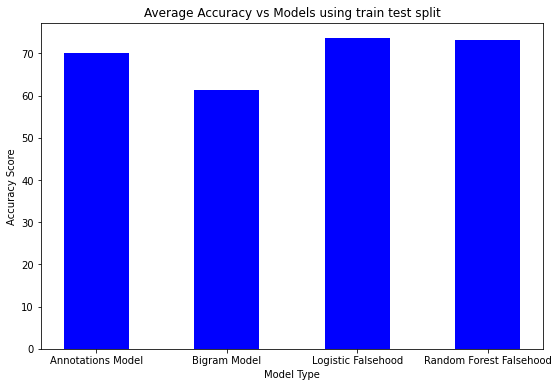

In [ ]:
#Acc Score Graph
# creating the dataset
data = {'Annotations Model':70.21, 'Bigram Model':61.25, 'Logistic Falsehood':73.61,
        'Random Forest Falsehood':73.13}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (9, 6))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.5)
 
plt.xlabel("Model Type")
plt.ylabel("Accuracy Score")
plt.title("Average Accuracy vs Models using train test split")
plt.show()

# Save and load Model

In [ ]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
import pickle

def saveModel(filename):
# save the model to disk
  pickle.dump(fakemodelLog, open(filename, 'wb'))

def loadModel(filename):
  # load the model from disk
  loaded_model = pickle.load(open(filename, 'rb'))


In [ ]:
link = "https://www.britannica.com/science/winter-solstice?utm_medium=mendel-homepage&utm_source=4up&utm_campaign=4up-1&utm_term=20211221"

sentenceList = scrape(link)
BiResults = biasmodelBiGram.predict(sentenceList)
BiProba = biasmodelBiGram.predict_proba(sentenceList)
AnnoResults = biasmodelAnno.predict(sentenceList)
AnnoProba = biasmodelAnno.predict_proba(sentenceList)
LogResults = (fakemodelLog.predict(sentenceList))
LogProba = (fakemodelLog.predict_proba(sentenceList))
RanResults = (fakemodelRan.predict(sentenceList))
RanProba = (fakemodelRan.predict_proba(sentenceList))
for i in range(0, len(sentenceList)):
  print("******************** " + "Test Case " + str(i) + " ********************")
  print("The Sentence Is: " + sentenceList[i])
  print("Determining Fake Models (0 is fake and 1 is true): ")
  print("Logistic Regression Returned: " + str(LogResults[i]) + " With the Proba of 0 being: " + str(int(100*LogProba[i][0]))+"% With the Proba of 1 being: " +str(int(100*LogProba[i][1])) + "%")
  print("Random Forest Returned: " + str(RanResults[i]) + " With the Proba of 0 being: " + str(int(100*RanProba[i][0]))+"% With the Proba of 1 being: " +str(int(100*RanProba[i][1])) + "%")
  print("Determining Bias Models (Anno: 0 is nonbias and 1 is bias): ")
  print("Bigram Method Returned: " + str(BiResults[i]) + " With the Proba of 0 being: " + str(int(100*BiProba[i][0]))+"% With the Proba of 1 being: " +str(int(100*BiProba[i][1])) + "%")
  print("Anno Data Returned: " + str(AnnoResults[i]) + " With the Proba of 0 being: " + str(int(100*AnnoProba[i][0]))+"% With the Proba of 1 being: " +str(int(100*AnnoProba[i][1])) + "%")

NameError: ignored



# Run Model on Articles

